# Linear Models and Interpretability

## TODO

Tasks: 
- Exploratory Data Analysis to check Assumptions: Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met. 
- Linear Regression: Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.
- Logistic Regression: Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.
- Generalized Additive Model (GAM): Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model. 
- Model Comparison: Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.

Rubric:
- Notebook is well documented and includes details and references to the dataset and models used
- Assumptions are evaluated with exploratory data analysis and explained in markdown inside the notebook
- Code implementing the linear regression model is correct
- Code implementing the linear regression model is clear and well documented
- Linear regression model is interpreted appropriately and interpretation is discussed in markdown
- Code implementing the logistic regression model is correct
- Code implementing the logistic regression model is clear and well documented
- Logistic regression model is interpreted appropriately and interpretation is discussed in markdown
- Code implementing the GAM is correct
- Code implementing the GAM is clear and well documented
- GAM is interpreted appropriately and interpretation is discussed in markdown
- A discussion of the strengths and weaknesses of each approach is included in markdown
- Recommendations for which model(s) the telecommunications company should use to address their customer churn problem are provided and explained in markdown


## Exploratory Data Analysis 

In [112]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns

### Retrieve Dataset

The target of the analysis is the Kaggle Telco Customer Churn dataset (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data). First, we'll retrieve and validate. 

In [113]:
# NOTE: this cell straight from the Kaggle project
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/jason/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [114]:
!ls $path

WA_Fn-UseC_-Telco-Customer-Churn.csv


In [115]:
df = pd.read_csv(path + f"/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [116]:
assert(len(df.customerID.unique()) == len(df))

The dataset provides features about a customer, with one row per customer (who are each uniquely identified by the `customerID` column), and are now redundant given our index. 

In [117]:
df.drop(['customerID'], axis=1, inplace=True) 

### Characterize Predictors

Next we'll inspect the predictor variables and characterize their distribution as well as their relationship to one another. 

**Linearity Check** 

Inspect the predictors' relationship with the target

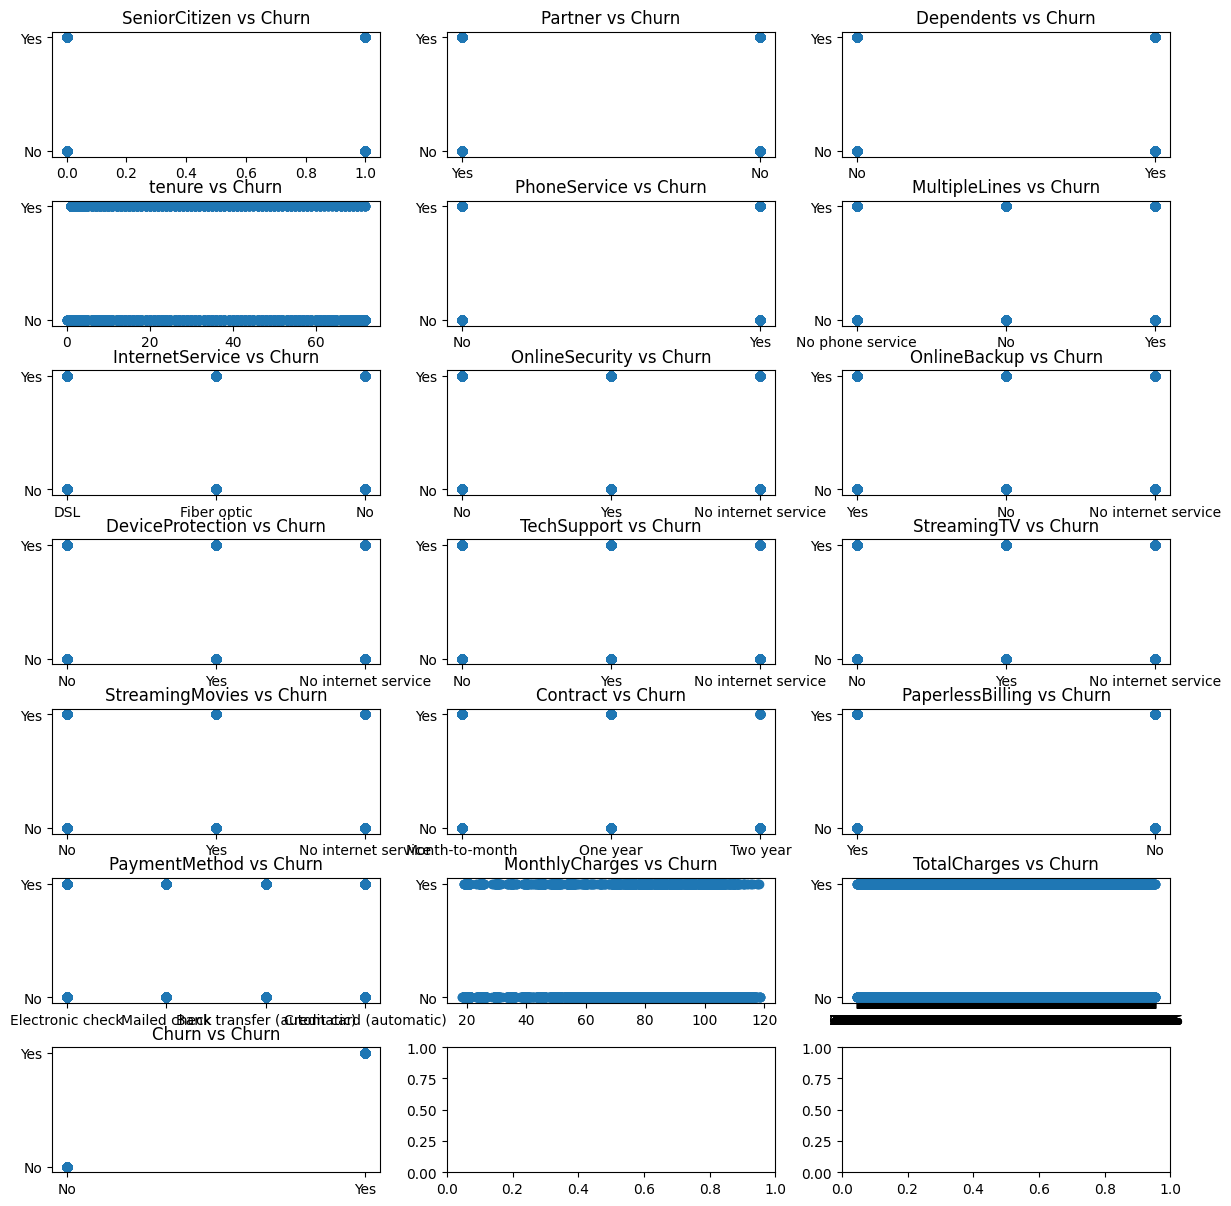

In [118]:
features = df.columns[1:]
target = "Churn"
h = 7
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,12))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].scatter(x=df[feature], y=df[target])
     axs[row, col].set_title(f"{feature} vs {target}")
     
plt.show()
     

The only linear relationship that's evident here is between churn and itself, no intervention appears to be necessary here.

**Independence** 

To test independence we need a numerical representation of each feature. Inventory the unique values and encode using the appropriate method (binarize or one-hot)

In [119]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [120]:
from sklearn.preprocessing import binarize, label_binarize, OneHotEncoder

In [121]:
for col in df.columns: 
    if df[col].dtype == 'object': 
        print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


We need to transform our features to support this analysis as well as later modeling. Copy the DF so we can retain both representations. 

In [122]:
dfm = df.copy()

In [123]:
dfm.gender = label_binarize(df.gender, classes=df.gender.unique())
dfm.Partner = label_binarize(df.Partner, classes=df.Partner.unique())
dfm.Dependents = label_binarize(df.Dependents, classes=df.Dependents.unique())
dfm.PhoneService = label_binarize(df.PhoneService, classes=df.PhoneService.unique())
dfm.PaperlessBilling = label_binarize(df.PaperlessBilling, classes=df.PaperlessBilling.unique())
dfm.Churn = label_binarize(df.Churn, classes=df.Churn.unique())

In [124]:
def onehot_encode(df, column, drop_source=True): 
    """
    One-hot encode the target column
    """
    enc = OneHotEncoder(handle_unknown='error', sparse_output=False)
    onehot = enc.fit_transform(df.loc[:,[column]])
    for i, feature in enumerate(enc.get_feature_names_out()): 
        df[feature] = onehot[:,i]

    return df.drop([column], axis=1) if drop_source else df

In [125]:
dfm = onehot_encode(dfm, 'MultipleLines')
dfm = onehot_encode(dfm, 'InternetService')
dfm = onehot_encode(dfm, 'OnlineSecurity')
dfm = onehot_encode(dfm, 'OnlineBackup')
dfm = onehot_encode(dfm, 'DeviceProtection')
dfm = onehot_encode(dfm, 'TechSupport')
dfm = onehot_encode(dfm, 'StreamingTV')
dfm = onehot_encode(dfm, 'StreamingMovies')
dfm = onehot_encode(dfm, 'Contract')
dfm = onehot_encode(dfm, 'PaymentMethod')

In [126]:
dfm.TotalCharges = df.TotalCharges.apply(lambda x: 0 if x==' ' else x)
dfm.TotalCharges = dfm.TotalCharges.astype(float)

In [127]:
dfm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,1,0,0,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,1,0,34,1,1,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,1,0,2,1,0,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,0,45,0,1,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,1,0,2,1,0,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,1,24,1,0,84.80,1990.50,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,0,0,1,72,1,0,103.20,7362.90,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,0,0,1,11,0,0,29.60,346.45,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,0,0,4,1,0,74.40,306.60,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [128]:
cm = dfm.corr()


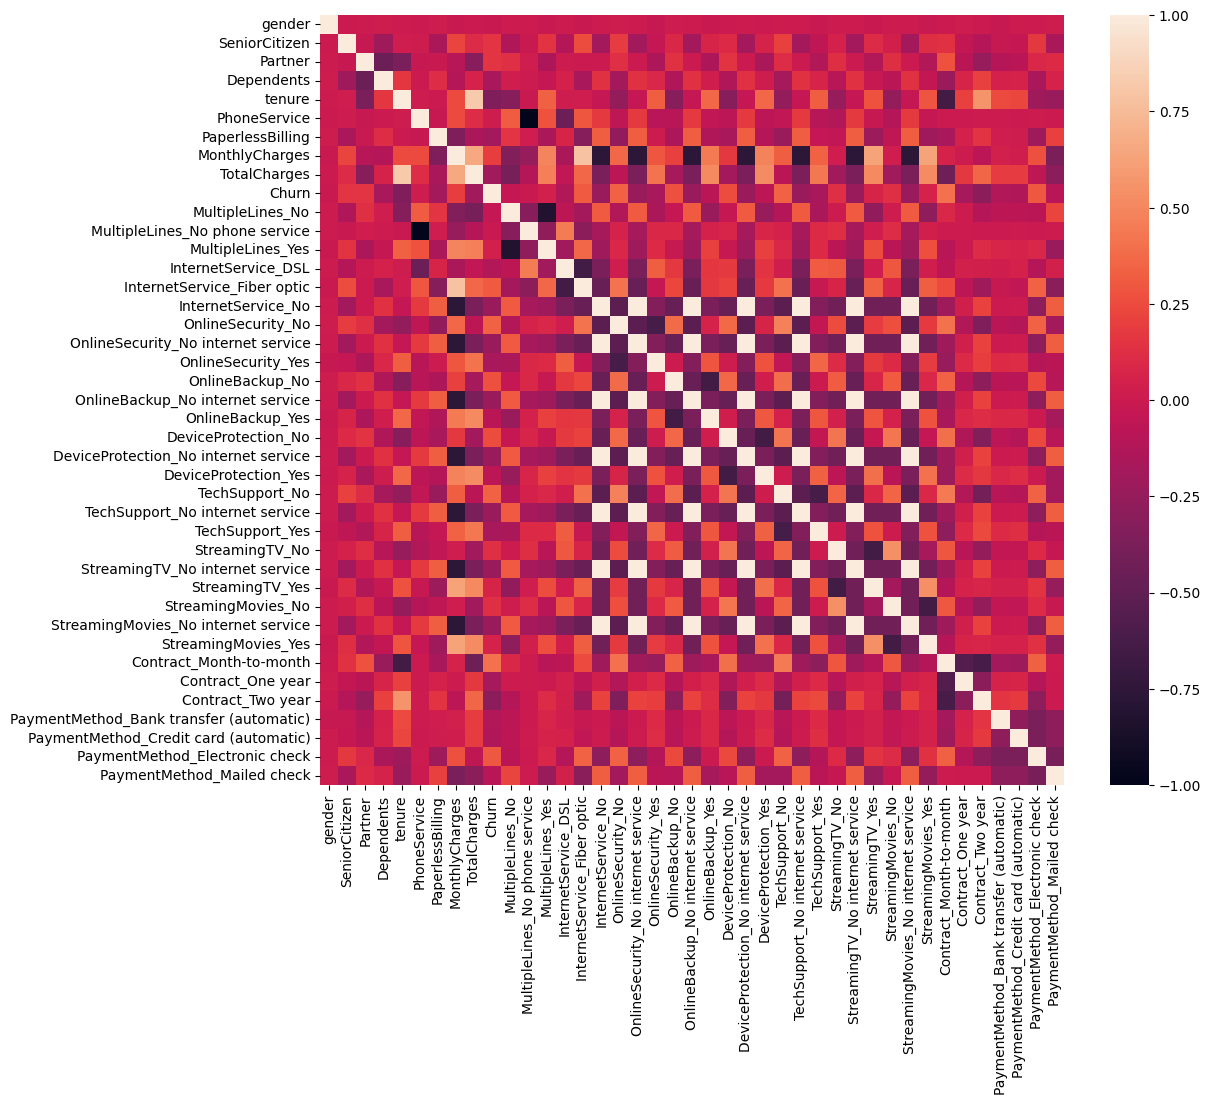

In [129]:
plt.figure(figsize=(12, 10))
_ = sns.heatmap(cm)

With an idea of what correlations exist, we threshold to determine the most problematic features. 

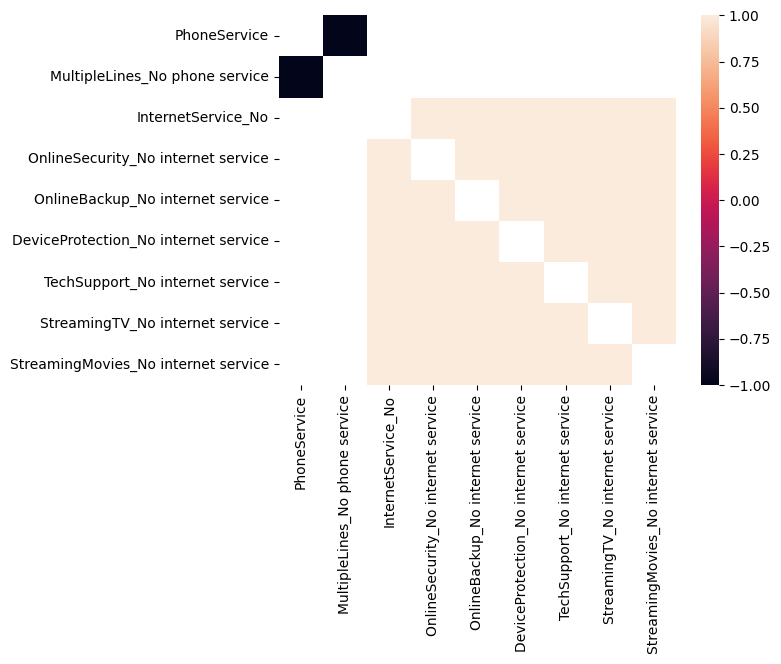

In [130]:
np.fill_diagonal(cm.to_numpy(), 0)
cm_thresh = cm[(cm > 0.85) | (cm <-0.85)]
cm_thresh = cm_thresh.dropna(how='all')
cm_thresh = cm_thresh.dropna(how='all', axis=1)
_ = sns.heatmap(cm_thresh)

In [131]:
cm_thresh.columns

Index(['PhoneService', 'MultipleLines_No phone service', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service'],
      dtype='object')

Here we can see that: 
1. The presence or absence of Internet service is correlated to the analogous value in a number of categorical features. This correlation is unambiguous and is a redundant coding for the same variable (lack of Internet). We'll remove the associated feature to get a clearer picture of the relationship between the remaining one-hot features, which do not exhibit any strong correlation. 
2. The lack of multiple phone lines is 100% correlated to users who have no phone service. This is also a redundant coding and we'll remove. 

In [132]:
dfm.drop([
    'MultipleLines_No phone service', 
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service', 
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
    ], axis=1, inplace=True)

**Homesceadisticity**

Here we need residuals, postpone until modeling phase. 

**Normality**

Also need residuals, postpone until modeling phase. 

**Outliers**

Here we look for any outliers that may have an outside influence on our modeling. 

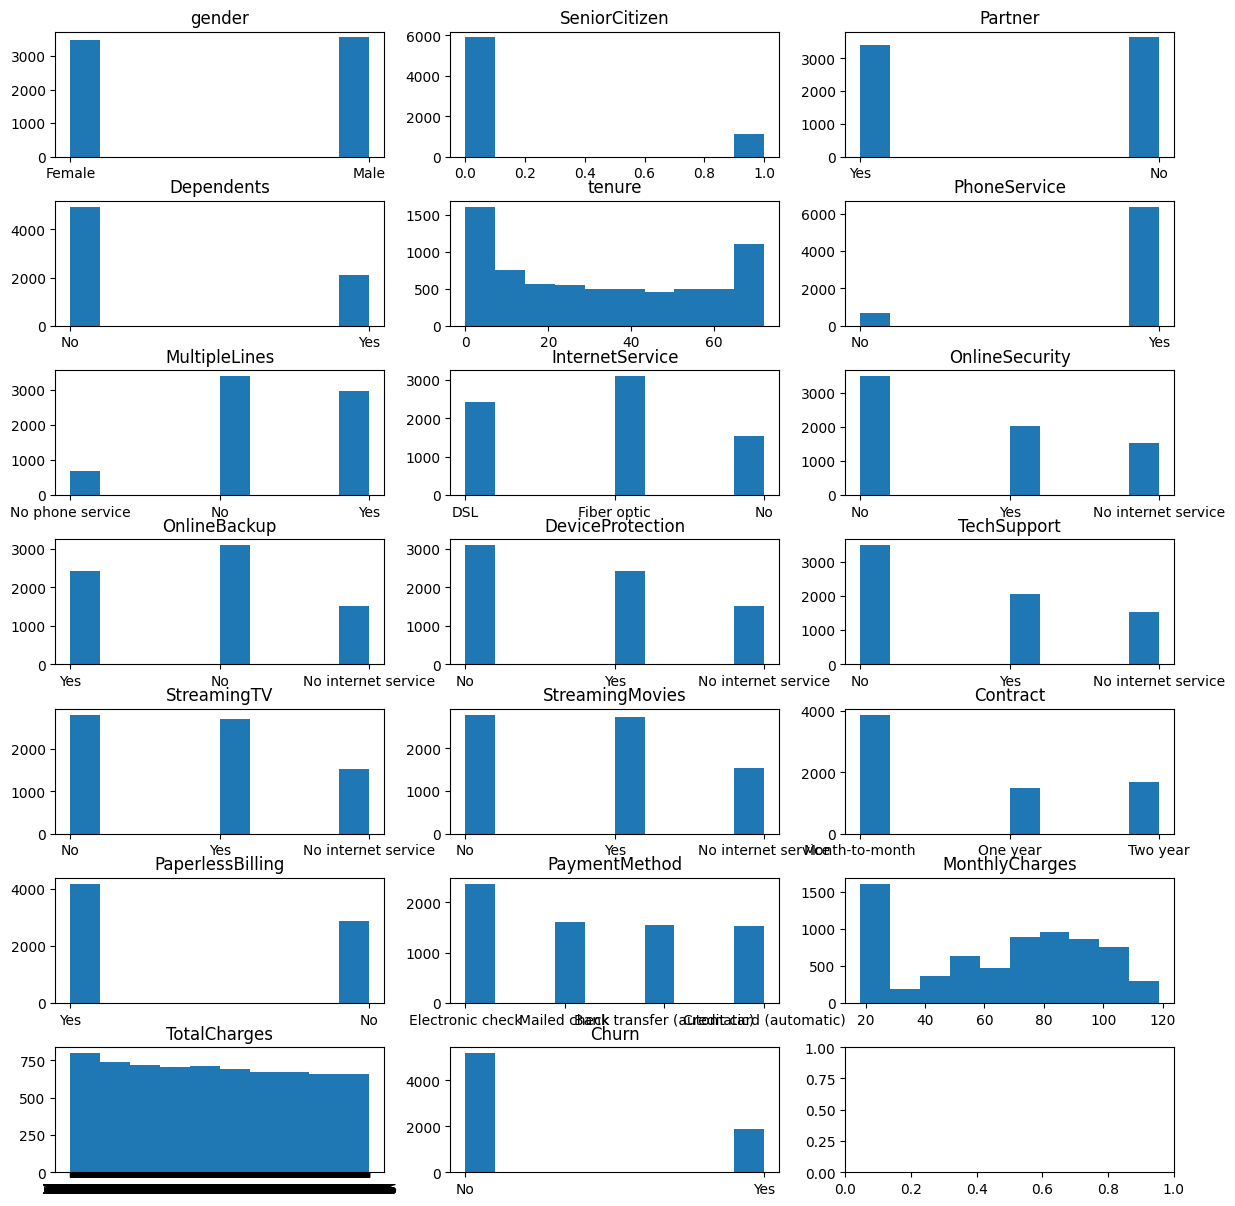

In [133]:
# Plot the distribution of all variables and the target
features = df.columns
h = 7
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,12))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].hist(df[feature])
     axs[row, col].set_title(feature)
     
plt.show()
     

There do not appear to be any outliers here, though some additional scrutiny is warranted on the monthly charges and tenure features. 

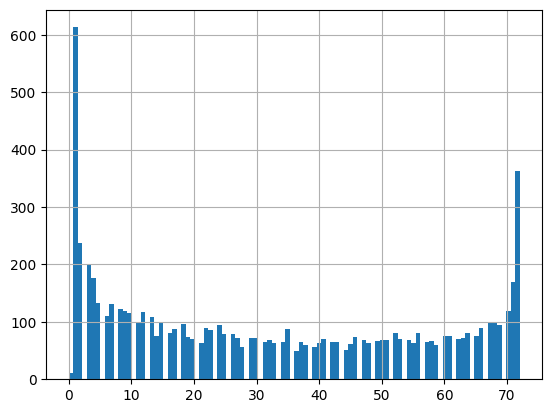

In [140]:
_ = dfm.tenure.hist(bins=100)

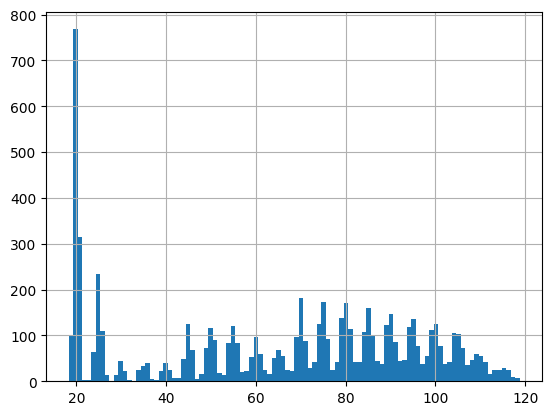

In [141]:
_ = df.MonthlyCharges.hist(bins=100)

We conclude we have met our expectations surrounding outliers and no further cleaning or transformations are required. 

## Modeling

Separate our data into predictors and target. 

In [143]:
train = dfm.drop(['Churn'], axis=1)
target = dfm.Churn

### Linear Regression

In [142]:
from sklearn.linear_model import LinearRegression 

In [144]:
model = LinearRegression()
model.fit(X=train, y=target)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [146]:
preds = model.predict(train)

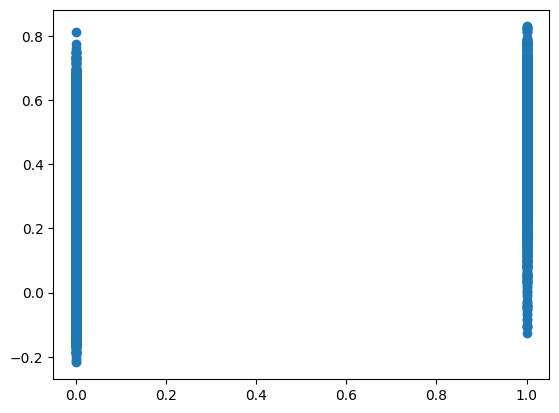

In [148]:
plt.scatter(x=target, y=preds)

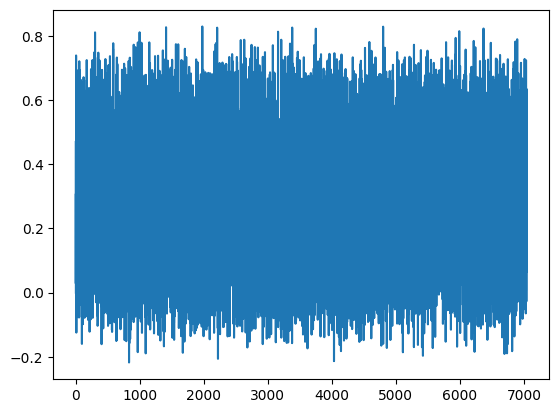

In [152]:
plt.plot(preds)

### Logistic Regression 

In [153]:
from sklearn.linear_model import LogisticRegression

In [155]:
model = LogisticRegression()
model.fit(X=train, y=target)

/Users/jason/Local/school/590/assignment2/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [156]:
preds = model.predict(train)

### Generalized Additive Model 

In [160]:
from pygam import LinearGAM, s

In [173]:
splines = s(0)
for i in range(1, train.shape[1]): 
    splines = splines + s(i) 

gam = LinearGAM(splines)

In [182]:
gam.gridsearch(train.to_numpy(), target.to_numpy())

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:20
 18% (2 of 11) |####                     | Elapsed Time: 0:00:04 ETA:   0:00:22
 27% (3 of 11) |######                   | Elapsed Time: 0:00:07 ETA:   0:00:19
 36% (4 of 11) |#########                | Elapsed Time: 0:00:09 ETA:   0:00:16
 45% (5 of 11) |###########              | Elapsed Time: 0:00:11 ETA:   0:00:13
 54% (6 of 11) |#############            | Elapsed Time: 0:00:13 ETA:   0:00:11
 63% (7 of 11) |###############          | Elapsed Time: 0:00:15 ETA:   0:00:09
 72% (8 of 11) |##################       | Elapsed Time: 0:00:18 ETA:   0:00:06
 81% (9 of 11) |####################     | Elapsed Time: 0:00:20 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:22 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + intercept,
   tol=0.0001, verbose=False)

In [ ]:
features = df.columns
h = 7
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,12))

In [206]:
plot_columns = train.columns

<Figure size 640x480 with 0 Axes>

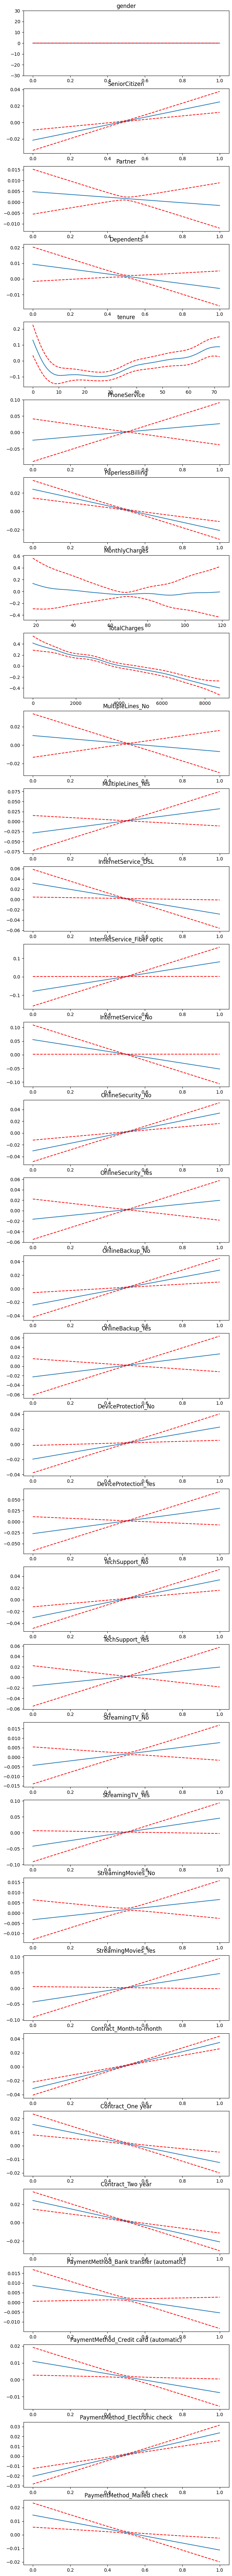

In [208]:

# Code snippet mined from PyGAM documentation here: https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Regression

plt.figure()
fig, axs = plt.subplots(len(plot_columns),1, figsize=(8,100))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(plot_columns[i]);


In [205]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.1451
Link Function:                     IdentityLink Log Likelihood:                                -18299.1018
Number of Samples:                         7043 AIC:                                            36688.4937
                                                AICc:                                           36689.0892
                                                GCV:                                                0.1365
                                                Scale:                                              0.1349
                                                Pseudo R-Squared:                                   0.3122
Feature Function                  Lam

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_97116/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Comparison of Models